# Postprocess to compute the time series of cumulative strain

Compute time series of strain with the gaussian weighting of station distance.
2023.2.1 Kurama Okubo

- 2023.5.1 update for the archived dataset in 2023/04/16
- 2023.5.5 synchronize the time with uniform_tvec
- 2023.7.5-6 Major update: Weighting with area of triangular elements by the integration of Gaussian distribution; rotation of axial strain.

In [1]:
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import h5py
import glob
import matplotlib as mpl
import seaborn as sns

from pyproj import Proj, Geod # used to compute the area of triangular element
from BP_rotate_strain import rotate_strain, compute_axialstrain

import shutil
from tqdm import tqdm

import geopy.distance as gd # to compute distance from lat lon
from scipy import integrate

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["xtick.minor.width"] = 0
plt.rcParams["xtick.minor.visible"] = True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True


# Workflow
1. Read the dataframe of strain and location of GPS created by `02_postprocess_cumulativestrain_prepareGMTinput.ipynb`
2. Read the BP network
3. Compute weight using the integral of Gaussian distribution with each BP station.
4. Compute the weighted average of strain.

- We compute only the cases with the single-station correlations.

# 1. Read Strain

In [2]:
# Read strain
df_deltastrain_all = pd.read_csv("../data/df_deltastrain_all.csv", index_col=False)

# 2. Read BP stations

In [3]:
# read BP network
df_BPstation = pd.read_csv("../data/BP_gmap-stations.txt", comment="#", header=None, sep="|")
df_BPstation = df_BPstation[[1, 3, 2]]
df_BPstation.columns = ["station", "lon", "lat"]

In [4]:
df_BPstation

,station,lon,lat
0,CCRB,-120.55158,35.95718
1,EADB,-120.42262,35.89522
2,FROB,-120.48688,35.91095
3,GHIB,-120.34728,35.83225
4,JCNB,-120.43112,35.93897
5,JCSB,-120.43400,35.92117
6,LCCB,-120.51423,35.98006
7,MMNB,-120.49600,35.95650
8,RMNB,-120.47772,36.00087
9,SCYB,-120.53661,36.00942


In [5]:
# Select the snap shot at the reference snap
ref_year = 2009
ref_doy = 3 # some station has a lack of data on the beginning of 2009, so we start from doy=3 to obtain references of all the triangulars.
df_refsnap = df_deltastrain_all[(df_deltastrain_all["year"]==ref_year) & (df_deltastrain_all["doy"]==ref_doy)].sort_values(by="triID")
Ntri = len(df_refsnap)

# 3. Compute the weight with the integral of Gaussian

In [6]:
# Prepare the projection function from latlon to utm
UTMzone_BP = 10; 
proj_BP = Proj(proj='utm', zone=UTMzone_BP, ellps='WGS84')

In [7]:
def f_Gaussian2D(t, s, a, b, v0, gauss_sig):
    """
    Return two-dimensional Gaussian distribution in the triangular element, G(s, t).
    Input:
    a, b, v0: vectors to v0 and along the edges of triangular element 
    sigma: standard deviation of Gaussian
    """
    p = np.linalg.norm(np.array(v0) + s * np.array(a) + t * np.array(b))
    J = np.abs(a[0]*b[1]-b[0]*a[1])
    return (1/(2*np.pi*gauss_sig**2)) * np.exp(-(p**2)/(2*gauss_sig**2)) * J

In [8]:
gauss_sig = 5.0 # extent of gaussian weight [km]
# maxdist = 30.0 # exclude the stations outside of this distance [km]

df_gaussweight = pd.DataFrame(columns=["triID", "area", "dist", "weight", "BPstation"])

for i, row in df_BPstation.iterrows():
    BP_stid = row.station
    df_st = df_BPstation[df_BPstation["station"]==BP_stid]
    # df_st.lon.values[0]
    for i in range(Ntri):
        snap_triid = i+1

        # get edges 
        df_snap_ref = df_refsnap.loc[df_refsnap["triID"]==snap_triid]
        lon1, lat1 = (df_snap_ref["lon1"].values[0], df_snap_ref["lat1"].values[0])
        lon2, lat2 = (df_snap_ref["lon2"].values[0], df_snap_ref["lat2"].values[0])
        lon3, lat3 = (df_snap_ref["lon3"].values[0], df_snap_ref["lat3"].values[0])
        mlon, mlat = (np.mean([lon1,lon2,lon3]), np.mean([lat1,lat2,lat3]))

        # compute distance between center of triangle and BP station
        coords1 = (mlat, mlon)
        coords2 = (df_st.lat.values[0], df_st.lon.values[0])
        dist_st = gd.geodesic(coords1, coords2).km # same unit with gauss_sig

        # UPDATE: compute integral of Gaussian on the triangular element
        #1. convert coordinates from latlon to utm
        st_x, st_y = proj_BP(df_st.lon.values[0], df_st.lat.values[0])
        x0, y0 = proj_BP(lon1, lat1) # the choice of v0 does not matter
        x1, y1 = proj_BP(lon2, lat2) # the choice of v0 does not matter
        x2, y2 = proj_BP(lon3, lat3) # the choice of v0 does not matter

        v0 = np.array([x0 - st_x, y0 - st_y])/1e3 #[m] -> [km]
        v1 = np.array([x1 - st_x, y1 - st_y])/1e3 #[m] -> [km]
        v2 = np.array([x2 - st_x, y2 - st_y])/1e3 #[m] -> [km]

        a = v1-v0
        b = v2-v0

        A = 0.5*np.abs(np.cross(a, b))/1e6 #[km^2]
        
        # Compute the integral of Gaussian on the triangular element
        gaussweight, err = integrate.dblquad(f_Gaussian2D, 0, 1, 0, lambda s: 1-s, args=(a, b, v0, gauss_sig),)
#         print(err)
        assert err < 1e-8

        df_gaussweight = pd.concat([df_gaussweight, pd.DataFrame([[snap_triid, A, dist_st, gaussweight, BP_stid]], columns=["triID", "area", "dist", "weight", "BPstation"])])


In [9]:
# check if the sum of weight is equal to unity
for i, row in df_BPstation.iterrows():
    BP_stid = row.station
    w_sum = df_gaussweight[df_gaussweight["BPstation"]==BP_stid]["weight"].sum()
    print(f"{BP_stid} weight sum: {w_sum:.4f}")

CCRB weight sum: 1.0000
EADB weight sum: 1.0000
FROB weight sum: 1.0000
GHIB weight sum: 1.0000
JCNB weight sum: 1.0000
JCSB weight sum: 1.0000
LCCB weight sum: 1.0000
MMNB weight sum: 1.0000
RMNB weight sum: 1.0000
SCYB weight sum: 1.0000
SMNB weight sum: 1.0000
VARB weight sum: 1.0000
VCAB weight sum: 1.0000


## Plot the weight

In [10]:
df_plotgaussian = pd.DataFrame(columns=["mlat", "mlon", "weight", "BPstation"])

for i, raw in df_BPstation.iterrows():
    BP_stid = raw.station
    df_weight_st = df_gaussweight[df_gaussweight["BPstation"]==BP_stid]
    sum_weight = df_weight_st.weight.sum()

    assert np.abs(sum_weight - 1.0) < 1e-8 # check the sum of weight is unity

    for i in range(Ntri):
        snap_triid = i+1

        # get edges 
        df_snap_ref = df_refsnap.loc[df_refsnap["triID"]==snap_triid]
        lon1, lat1 = (df_snap_ref["lon1"].values[0], df_snap_ref["lat1"].values[0])
        lon2, lat2 = (df_snap_ref["lon2"].values[0], df_snap_ref["lat2"].values[0])
        lon3, lat3 = (df_snap_ref["lon3"].values[0], df_snap_ref["lat3"].values[0])
        mlon, mlat = (np.mean([lon1,lon2,lon3]), np.mean([lat1,lat2,lat3]))
        weight = df_weight_st[df_weight_st["triID"]==snap_triid].weight.values[0]
        
        df_plotgaussian = pd.concat([df_plotgaussian, pd.DataFrame([[mlat, mlon, weight, BP_stid]], columns=["mlat", "mlon", "weight", "BPstation"])])


In [11]:
cmap1 = sns.color_palette("viridis", as_cmap=True)
# manipulate colorpallet so than 0 is in gray
cmap1._lut[0:2] = np.array([ 1.0, 1.0,  1.0,  1.0])

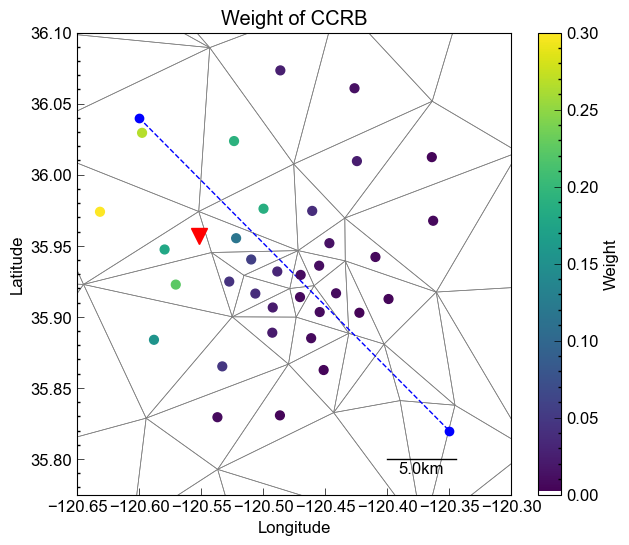

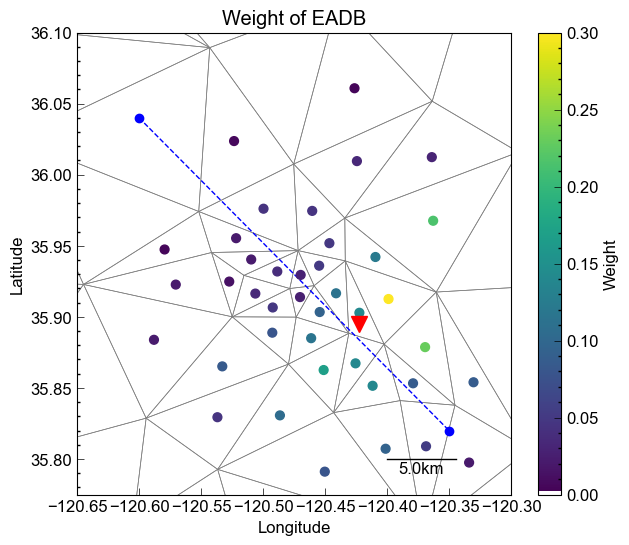

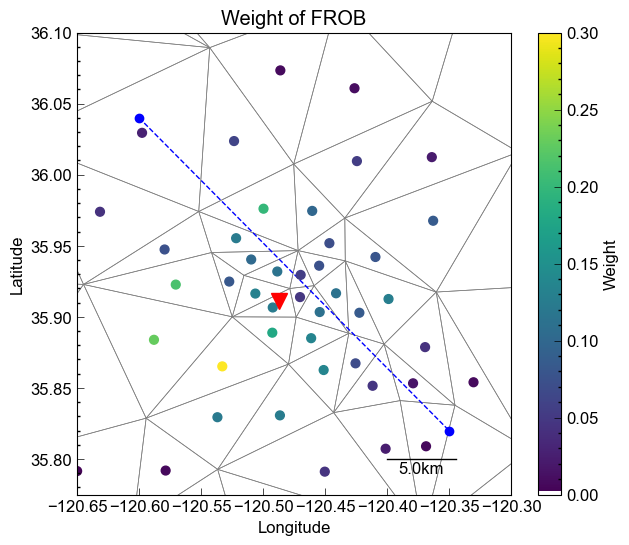

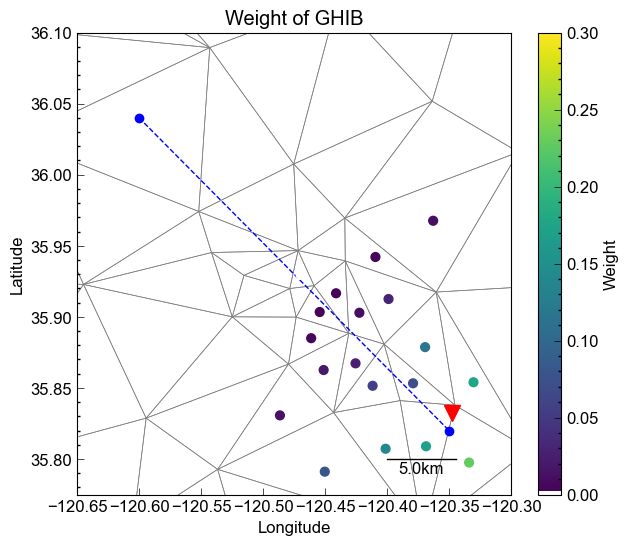

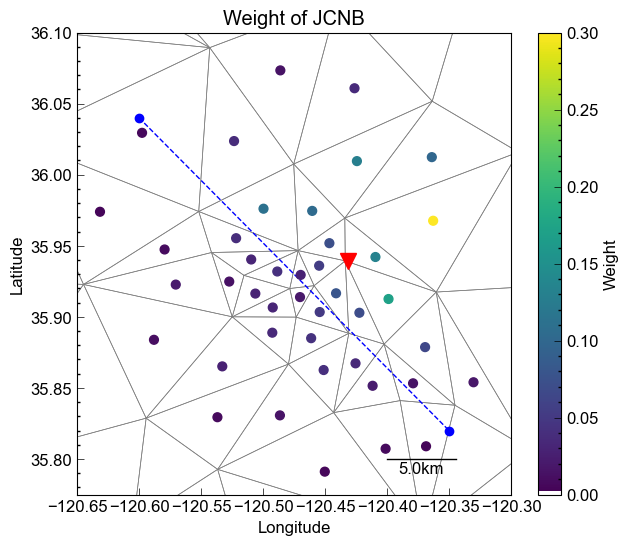

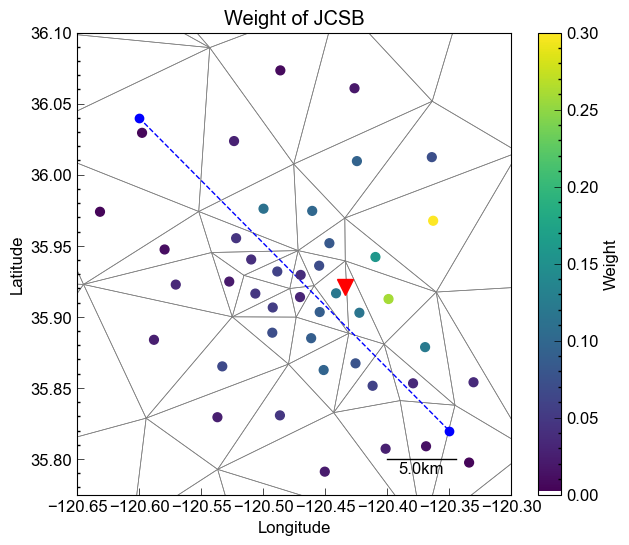

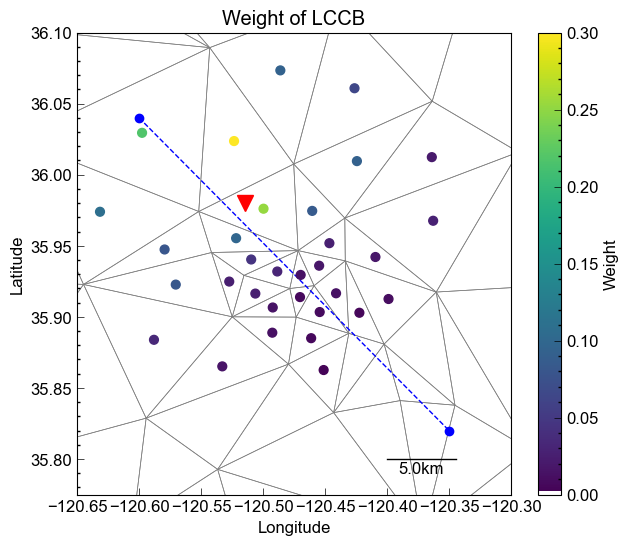

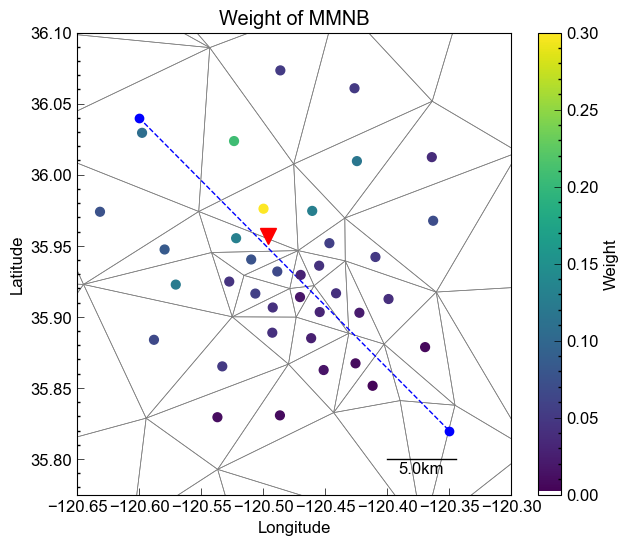

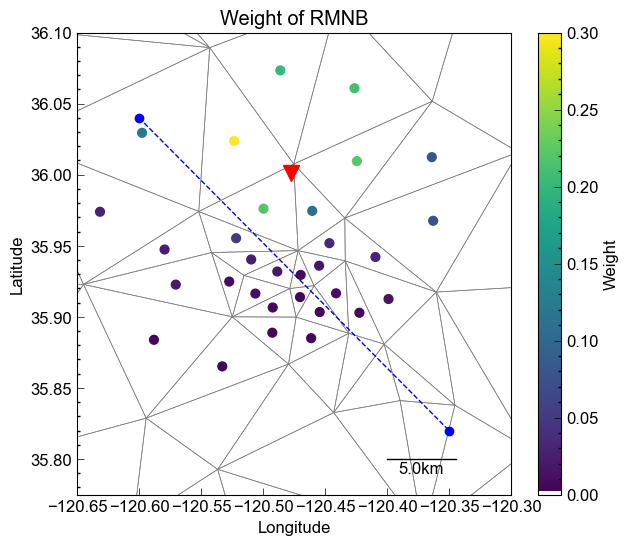

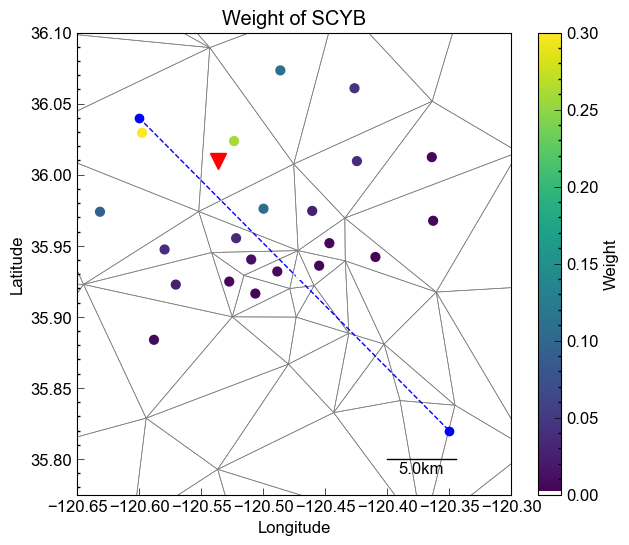

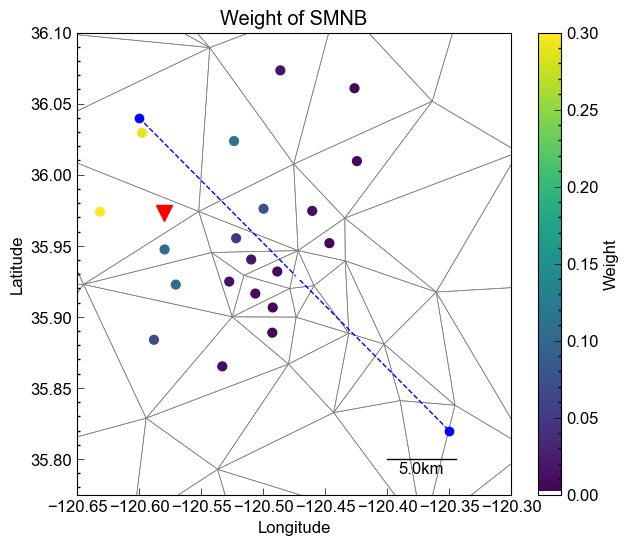

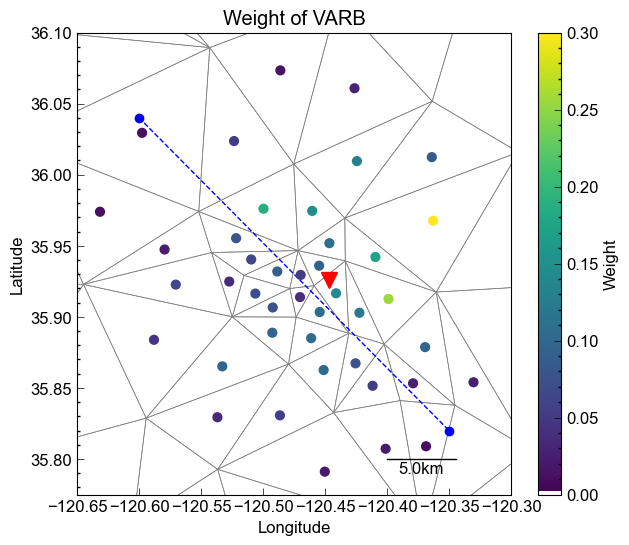

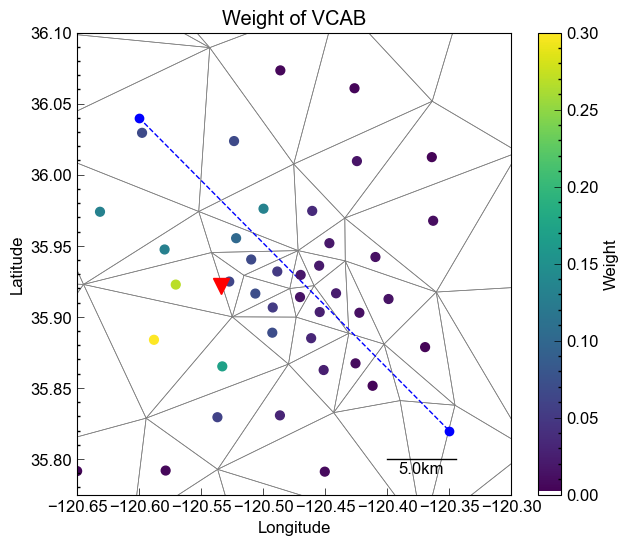

In [12]:
# Plot in space
f_lon_min = -120.65
f_lon_max = -120.3
f_lat_min = 35.775
f_lat_max = 36.1

approx_faultloc = [-120.6, 36.04, -120.35, 35.82] # selected with try and error

# output_imgdir_weight = "./figure/spatial_gaussianweight"
# if not os.path.exists(output_imgdir_weight):
#     os.makedirs(output_imgdir_weight)
    
for i, raw in df_BPstation.iterrows():
# for i, raw in df_BPstation.iloc[1:2].iterrows():
    BP_stid = raw.station
    df_plotweight = df_plotgaussian[df_plotgaussian["BPstation"]==BP_stid]
    df_st = df_BPstation[df_BPstation["station"]==BP_stid]

    fig, ax = plt.subplots(1,1, figsize=(7, 6))

    ax.scatter(df_plotweight["mlon"], df_plotweight["mlat"], 40, c=df_plotweight["weight"], cmap=cmap1)
    ax.plot(df_st.lon, df_st.lat, "rv", ms=12)

    #---Plot triangular mesh---#
    for i, row in df_refsnap.iterrows():
        for meshedge in [[[row.lon1, row.lon2], [row.lat1, row.lat2]], [[row.lon2, row.lon3], [row.lat2, row.lat3]], [[row.lon3, row.lon1], [row.lat3, row.lat1]]]:
            ax.plot(meshedge[0], meshedge[1], "-", c="gray", lw=0.5, zorder=-10)
    
    #---Plot approximated fault loc---#
    ax.plot([approx_faultloc[0], approx_faultloc[2]], [approx_faultloc[1], approx_faultloc[3]], 
            'bo', ls="--", lw=1.0, zorder=-2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.set_xlim([f_lon_min, f_lon_max])
    ax.set_ylim([f_lat_min, f_lat_max])

    #---Plot scale---#
    scale_loc1 = [35.80, -120.40]
    scale_loc2 = [35.80, -120.34468] # found by try and error
    scale_dist_st = gd.geodesic([35.80, 120.40], [35.80, 120.34468]).km
#     print(f"scale length:{scale_dist_st}km")
    ax.plot([scale_loc1[1], scale_loc2[1]], [scale_loc1[0], scale_loc2[0]],'k-', lw=1.0, zorder=-2)
    ax.text((scale_loc1[1]+scale_loc2[1])/2, scale_loc1[0]-0.01, f"{scale_dist_st:.1f}km", ha="center")
    
    # color bar
    normalize = mpl.colors.Normalize(vmin=0, vmax=0.3)
    cbar=fig.colorbar(mpl.cm.ScalarMappable(norm=normalize, cmap=cmap1),
                     orientation='vertical', ax=ax, location = 'right',
                     label="Weight")

    # ax.axis('equal')

    ax.set_title(f"Weight of {BP_stid}")

#     plt.tight_layout()
#     foname = output_imgdir_weight+f"/debug_spatialweight_{BP_stid}.png"
#     plt.savefig(foname, dpi=300)
    
#     if i==len(df_BPstation)-1:
#         break
        
#     plt.clf()
#     plt.close()

# 4. Compute the weighted average of strain

We compute the dilation, max shear and the rotated axial strains. 
The rotated axial strain $\varepsilon^{ax}$ is written as followings:

$$\varepsilon^{ax} = \mathbf{n}^T \{ \mathbf{\varepsilon} \} \mathbf{n}$$

$$ = n_i n_j \varepsilon_{ij}. $$

Given the normal vector of $\mathbf{n} = [\cos\theta, \sin\theta]^T$,

$$\varepsilon^{ax} = \varepsilon_{11} \cos^2 \theta + \varepsilon_{12} \sin 2\theta +  \varepsilon_{22} \sin^2 \theta. $$


See `Appx/strain_rotation/check_strain_rotation_axialstrain.ipynb` for the formula of rotation.

In [13]:
# read uniform tvec for dv/v
fih5 = h5py.File("../../ModelFit/processed_data/dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5")
uniform_tvec_unix = np.array(fih5["uniform_tvec"])
uniform_tvec = np.array([datetime.datetime.fromtimestamp(x) for x in uniform_tvec_unix])
fih5.close()

average_missing_dist_threshold = 5.0 #10.0 #5.0 # [km] threshold if the element is missing within this distance, we skip the time step.

startyear = 2009

uniform_tinit_ind = np.where(uniform_tvec > datetime.datetime(startyear, 1, 1))[0][0] # initial day from the start year 
timestep = 6 # step of evaluating time for strain

In [14]:
uniform_tvec[uniform_tinit_ind::timestep]

array([datetime.datetime(2009, 1, 9, 0, 0),
       datetime.datetime(2009, 4, 9, 0, 0),
       datetime.datetime(2009, 7, 8, 0, 0),
       datetime.datetime(2009, 10, 6, 0, 0),
       datetime.datetime(2010, 1, 4, 0, 0),
       datetime.datetime(2010, 4, 4, 0, 0),
       datetime.datetime(2010, 7, 3, 0, 0),
       datetime.datetime(2010, 10, 1, 0, 0),
       datetime.datetime(2010, 12, 30, 0, 0),
       datetime.datetime(2011, 3, 30, 0, 0),
       datetime.datetime(2011, 6, 28, 0, 0),
       datetime.datetime(2011, 9, 26, 0, 0),
       datetime.datetime(2011, 12, 25, 0, 0),
       datetime.datetime(2012, 3, 24, 0, 0),
       datetime.datetime(2012, 6, 22, 0, 0),
       datetime.datetime(2012, 9, 20, 0, 0),
       datetime.datetime(2012, 12, 19, 0, 0),
       datetime.datetime(2013, 3, 19, 0, 0),
       datetime.datetime(2013, 6, 17, 0, 0),
       datetime.datetime(2013, 9, 15, 0, 0),
       datetime.datetime(2013, 12, 14, 0, 0),
       datetime.datetime(2014, 3, 14, 0, 0),
       datet

In [15]:
t_decimated = uniform_tvec[uniform_tinit_ind::timestep]
t_decimated[1]-t_decimated[0]

datetime.timedelta(days=90)

In [16]:
columns=["year", "doy", "datavalid_flag", "BPstation", "Decimal_time", "waverage_dilation", "waverage_maxshear"]
rotation_angles = np.linspace(0, 180, 37) #19) # orientations to compute the rotated axial strain components

print(f"Rotation angles: {rotation_angles}")
for strain_theta in rotation_angles:
    columns.append(f"waverage_E{int(strain_theta):d}")

Rotation angles: [  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135.
 140. 145. 150. 155. 160. 165. 170. 175. 180.]


In [17]:
df_gaussweight

,triID,area,dist,weight,BPstation
0,1,0.000009,78.874837,1.899423e-34,CCRB
0,2,0.000481,49.064287,5.968824e-14,CCRB
0,3,0.000399,43.074956,1.218787e-10,CCRB
0,4,0.000500,50.754325,4.735421e-14,CCRB
0,5,0.000139,28.800594,4.554380e-07,CCRB
...,...,...,...,...,...
0,122,0.000049,27.541321,3.313703e-07,VCAB
0,123,0.000020,19.479108,1.156369e-04,VCAB
0,124,0.000026,17.463657,8.634420e-04,VCAB
0,125,0.000009,15.912527,4.685233e-04,VCAB


In [18]:
uniform_tvec[104]

datetime.datetime(2006, 4, 25, 0, 0)

In [19]:
uniform_tvec[104].timetuple()

time.struct_time(tm_year=2006, tm_mon=4, tm_mday=25, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=115, tm_isdst=-1)

In [20]:
df_deltastrain_all

,triID,lon1,lat1,lon2,lat2,lon3,lat3,year,doy,E1,...,Een,w,theta,Eee,Enn,theta_SHmax,e_SHmax,Decimal time,theta_SHmax_delta,e_SHmax_delta
0,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2012,338,0.000007,...,0.000004,-0.000012,62.596103,-1.010000e-07,0.000005,114.21,-1.986100e-06,2012.9249,152.596103,-0.000002
1,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,308,0.000014,...,0.000007,-0.000008,64.897935,-1.317000e-06,0.000011,118.23,-5.617000e-07,2015.8452,154.897935,-0.000005
2,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,309,0.000014,...,0.000007,-0.000007,66.357190,-2.169000e-06,0.000011,118.61,-4.555800e-07,2015.8479,156.357190,-0.000005
3,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,310,0.000015,...,0.000008,-0.000007,63.946178,-8.660000e-07,0.000011,118.58,-4.864400e-07,2015.8507,153.946178,-0.000005
4,1,-119.909360,35.934703,-119.738034,35.731268,-119.535807,35.499842,2015,311,0.000014,...,0.000007,-0.000008,65.003093,-1.335000e-06,0.000010,118.04,-6.087500e-07,2015.8534,155.003093,-0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548579,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,346,0.000002,...,0.000002,-0.000012,16.044620,1.070000e-06,-0.000005,97.54,-5.170900e-05,2010.9493,106.044620,-0.000005
548580,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,347,0.000002,...,0.000002,-0.000012,15.779838,1.050000e-06,-0.000005,97.51,-5.169700e-05,2010.9521,105.779838,-0.000005
548581,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,348,0.000002,...,0.000002,-0.000012,15.963231,1.034000e-06,-0.000005,97.53,-5.171400e-05,2010.9548,105.963231,-0.000005
548582,126,-120.389458,35.841057,-120.402382,35.880812,-120.443057,35.832596,2010,334,0.000002,...,0.000002,-0.000012,16.254771,9.910000e-07,-0.000005,97.53,-5.153900e-05,2010.9164,106.254771,-0.000005


In [ ]:
df_straintimeseries_all = pd.DataFrame(columns=columns)

for BP_stid in df_BPstation.station:
# for BP_stid in [df_BPstation.iloc[5].station]:
    print(f"start processing {BP_stid}")

    for t1 in tqdm(uniform_tvec[uniform_tinit_ind::timestep]):
        # all the weight associated with the station
        df_weight_BPst = df_gaussweight[df_gaussweight["BPstation"]==BP_stid]
        df_weight_BPst = df_weight_BPst.set_index("triID")

        snapyear = t1.year
        snapdoy = t1.timetuple().tm_yday 

        # Evaluate NaN triangle and normalize the gaussian weight
        datavalid_flag = True
        for i in range(Ntri):
            snap_triid = i+1
            df_snap_tri = df_deltastrain_all.loc[(df_deltastrain_all["triID"] == snap_triid) & (df_deltastrain_all["year"]==snapyear) & (df_deltastrain_all["doy"]==snapdoy)]

            if df_snap_tri.empty:
                # the time snap in this triangle is not available due to the lack of data.
                # If the location of this triangle is within the average_missing_dist_threshold, we skip averaging this time snap because
                # the lack of close element around the seismic station causes nonnegligible bias in the weighted average.
                dist = df_weight_BPst[df_weight_BPst.index==snap_triid].dist.values[0]
                if dist < average_missing_dist_threshold:
                    datavalid_flag = False
                    break;
                else:
                    # we ignore this element with weighting zero
                    df_weight_BPst.loc[snap_triid, ["weight_flag"]] = 0.0
            else:
                    assert len(df_snap_tri) == 1 # check if the strain data is not duplicated

    #                     print(snapyear, snapdoy)
    #                     print(df_snap_tri)

                    # data exists at this snap
                    # compute dilation and max shear
                    df_weight_BPst.loc[snap_triid, ["dilation"]] = (df_snap_tri["E1"].values[0] +  df_snap_tri["E2"].values[0]) * 1e6
                    df_weight_BPst.loc[snap_triid, ["maxshear"]] = ((df_snap_tri["E1"].values[0] - df_snap_tri["E2"].values[0])/2)  * 1e6
                    df_weight_BPst.loc[snap_triid, ["Decimal time"]] = df_snap_tri["Decimal time"].values[0]
                    df_weight_BPst.loc[snap_triid, ["weight_flag"]] = 1.0

                    # compute rotated axial strains
                    for strain_theta_deg in rotation_angles:
                        df_weight_BPst.loc[snap_triid, [f"E{int(strain_theta_deg):d}"]] = compute_axialstrain(df_snap_tri["Eee"].values[0]*1e6,  df_snap_tri["Enn"].values[0]*1e6,
                                                                                                             df_snap_tri["Een"].values[0]*1e6, strain_theta_deg)
                        
        if datavalid_flag:
            # The sum of the weight is unity, whereas we need to rescale the weight due to the NaN triangle.
            # reference: https://stackoverflow.com/questions/18697532/gaussian-filtering-a-image-with-nan-in-python
            df_weight_BPst.loc[:, ["weight_mulflag"]] = df_weight_BPst["weight"].multiply(df_weight_BPst["weight_flag"], axis=0)
            
            # check if the sum of weight is close to unity
            if (1.0 - df_weight_BPst["weight_mulflag"].sum()) > 0.01: # print if the sum of weight is apart from unity due to NaN element
                print(1.0 - df_weight_BPst["weight_mulflag"].sum())
                print(df_weight_BPst["weight_mulflag"].sum())
            
            df_weight_BPst.loc[:, ["weight_normalized"]] = df_weight_BPst["weight_mulflag"].div(df_weight_BPst["weight_mulflag"].sum(), axis=0)

            # Check if the sum of normalized weight is unity
            assert np.round(df_weight_BPst["weight_normalized"].sum(), 10) == 1

            # Compute weighted average of dilation and max shear at this time snap
            dilation_weightedave_snap = df_weight_BPst["dilation"].multiply(df_weight_BPst["weight_normalized"], axis=0).sum()
            maxshear_weightedave_snap = df_weight_BPst["maxshear"].multiply(df_weight_BPst["weight_normalized"], axis=0).sum()

            dfdata = [snapyear, snapdoy, datavalid_flag, BP_stid, df_weight_BPst["Decimal time"].dropna().values[0],
                          dilation_weightedave_snap, maxshear_weightedave_snap]
            
            # Compute the weighted average of strain components
            for strain_theta_deg in rotation_angles:
                axialstrain_weightedave_snap = df_weight_BPst[f"E{int(strain_theta_deg):d}"].multiply(df_weight_BPst["weight_normalized"], axis=0).sum()
                dfdata.append(axialstrain_weightedave_snap)
                
            df_straintimesries_snap = pd.DataFrame([dfdata], columns=columns)
            df_straintimeseries_all = pd.concat([df_straintimeseries_all, df_straintimesries_snap])

    #             if  t1 > uniform_tvec[420]:
    #                 error()


In [22]:
df_straintimeseries_all

,year,doy,datavalid_flag,BPstation,Decimal_time,waverage_dilation,waverage_maxshear,waverage_E0,waverage_E5,waverage_E10,...,waverage_E135,waverage_E140,waverage_E145,waverage_E150,waverage_E155,waverage_E160,waverage_E165,waverage_E170,waverage_E175,waverage_E180
0,2009,9,True,CCRB,2009.0260,-0.012396,0.108474,-0.021220,-0.017167,-0.012780,...,-0.028225,-0.030499,-0.032034,-0.032785,-0.032728,-0.031864,-0.030221,-0.027848,-0.024817,-0.021220
0,2009,99,True,CCRB,2009.2726,-0.046978,0.322582,0.128871,0.116221,0.099326,...,0.036029,0.061582,0.084550,0.104235,0.120040,0.131483,0.138218,0.140039,0.136892,0.128871
0,2010,4,True,CCRB,2010.0123,0.138528,0.929938,0.686700,0.660037,0.615423,...,0.168792,0.274497,0.373966,0.464176,0.542387,0.606223,0.653743,0.683505,0.694603,0.686700
0,2010,94,True,CCRB,2010.2589,0.142533,0.946208,0.844888,0.797056,0.727172,...,0.279036,0.410217,0.531100,0.638011,0.727701,0.797447,0.845127,0.869294,0.869214,0.844888
0,2010,274,True,CCRB,2010.7521,0.442912,1.407029,1.313365,1.272114,1.198939,...,0.363481,0.550932,0.728371,0.890408,1.032119,1.149199,1.238090,1.296090,1.321439,1.313365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2019,317,True,VCAB,2019.8699,1.596502,6.036383,5.936539,5.621707,5.160316,...,2.161757,3.033297,3.836925,4.548226,5.145585,5.610853,5.929892,6.093009,6.095247,5.936539
0,2020,222,True,VCAB,2020.6079,1.649101,6.761228,6.368677,6.033173,5.539407,...,2.271597,3.212341,4.080533,4.849793,5.496749,6.001742,6.349429,6.529245,6.535727,6.368677
0,2020,312,True,VCAB,2020.8538,0.566609,5.970122,5.235857,4.955578,4.533333,...,1.464079,2.306142,3.086742,3.782161,4.371270,4.836167,5.162728,5.341030,5.365656,5.235857
0,2021,36,True,VCAB,2021.1000,0.682289,6.099361,5.415781,5.128089,4.694948,...,1.553925,2.416701,3.216413,3.928761,4.532102,5.008102,5.342299,5.524538,5.549283,5.415781


In [23]:
# Write the time series to the csv file
df_straintimeseries_all.to_csv("../data/BP_strain_timeseries_rotatedaxialstrain.csv")

# Plot the cumulative strain

In [24]:
output_imgdir = "../figure/timeseries"
if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)

In [25]:
cm = plt.cm.get_cmap("jet")
cm(0.2)

(0.0, 0.3, 1.0, 1.0)

In [ ]:
for BP_stid in df_BPstation.station:
    print(BP_stid)
    # BP_stid = "MMNB"

    df_timeseries_BPst = df_straintimeseries_all[df_straintimeseries_all["BPstation"]==BP_stid]

    fig, ax = plt.subplots(1,1, figsize=(8, 3))

    tvec = df_timeseries_BPst["Decimal_time"]

    ax.plot(tvec, df_timeseries_BPst["waverage_dilation"], "-s", c= "k", label="dilation", ms=4)
    ax.plot(tvec, df_timeseries_BPst["waverage_maxshear"], "-^", c= "g", label="max shear", ms=4)

    # plot rotated axial strain components
    Neax = len(rotation_angles)
    for i, strain_theta_deg in enumerate(rotation_angles):
        ax.plot(tvec, df_timeseries_BPst[f"waverage_E{int(strain_theta_deg):d}"], "-o", c=cm(i/Neax), label=f"E{int(strain_theta_deg):d}", ms=4)
        
        
    ax.set_ylabel('Strain change [με]')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.grid(True)
    ax.set_xlim([2009, 2023])
    ax.set_ylim([-15, 15])
    ax.legend(loc=2)
    ax.set_title(BP_stid)

    plt.tight_layout()
    foname = output_imgdir+f"/BPstrain_time_stations_{BP_stid}.png"
    plt.savefig(foname, dpi=300)
    

## GMT plot the region of gaussian weight 

We output the table of gaussian weighted region associated with the seismic stations.

In [27]:
fo_gaussianregion= open(f"../data/BP_gaussianregion.txt", "wt")

for i, row in df_BPstation.iterrows():
    fo_gaussianregion.write("{} {} {}k\n".format(row.lon, row.lat, gauss_sig*2)) # the 3rd column should be diameter, not radius

fo_gaussianregion.close()

# Conclusion

We computed the Gaussian weighted time series of cumulative strain with dilation, max shear, and the axial strain components rotated from 0 to 180 degrees. We compare this data to the evolution of dv/v in the next step.